In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# About Dataset
- The Brain Tumor Classification MRI dataset is a medical image dataset designed for developing deep learning models to classify brain tumors using MRI scans. It is typically organized into two main directories: Training and Testing, each containing subfolders corresponding to four categories—Glioma Tumor, Meningioma Tumor, Pituitary Tumor, and No Tumor. These categories represent different types of brain tumors as well as healthy brain scans, allowing models to learn not only to detect tumors but also to distinguish between tumor types. The dataset provides a diverse set of MRI images that can be used to train and evaluate convolutional neural networks (CNNs) for accurate and automated brain tumor diagnosis. This classification task plays a vital role in supporting radiologists and improving early detection and treatment planning for patients with brain tumors.

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2025-04-12 03:52:07.416569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744429927.657127      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744429927.732191      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define Dataset Paths

In [3]:
train_path = "/kaggle/input/brain-tumor-classification-mri/Training"
test_path = "/kaggle/input/brain-tumor-classification-mri/Testing"

# Data Augmentation & Preprocessing
## Why Data Augmentation?
- To make the model more powerful and avoid overfitting.

- It applies:

1. Zooming

2. Rotation

3. Flipping

4. Rescaling pixels (0 to 1)

## For Training Data

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # To convert pixel value from 0-255 to 0-1
    shear_range=0.2,         # Shear Transformation (Tilting Image)
    zoom_range=0.2,          # Random Zoom
    horizontal_flip=True     # Random Flip Image Horizontally
)

## For Testing Data

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

#  Load Images from Folder
##  Load Training Images:

In [6]:
train = train_datagen.flow_from_directory(
    train_path,              # Folder Path
    target_size=(128, 128),  # Resize all images to 128x128
    batch_size=32,           # Train 32 images at a time
    class_mode='categorical' # Because it's multi-class classification (4 classes)
)

Found 2870 images belonging to 4 classes.


## Load Testing Images

In [7]:
test = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 394 images belonging to 4 classes.


## Output Class Labels (Auto-detected)

In [8]:
train.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# To Check Class Distribution 

In [9]:
# Function to Count Images
def get_class_distribution(path):
    classes = os.listdir(path)
    data = []
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        count = len(os.listdir(class_path))
        data.append({'Tumor_Type': class_name, 'Image_Count': count})
    return pd.DataFrame(data)

# Training Data Class Count
train_df = get_class_distribution(train_path)
print("Training Data Class Distribution:")
print(train_df)

# Testing Data Class Count
test_df = get_class_distribution(test_path)
print("\nTesting Data Class Distribution:")
print(test_df)

Training Data Class Distribution:
         Tumor_Type  Image_Count
0          no_tumor          395
1   pituitary_tumor          827
2  meningioma_tumor          822
3      glioma_tumor          826

Testing Data Class Distribution:
         Tumor_Type  Image_Count
0          no_tumor          105
1   pituitary_tumor           74
2  meningioma_tumor          115
3      glioma_tumor          100


# Visualization

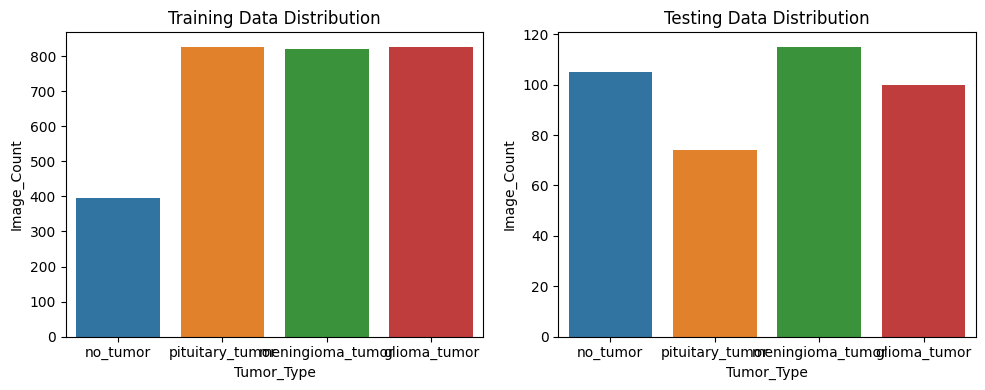

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.barplot(x='Tumor_Type', y='Image_Count', data=train_df)
plt.title('Training Data Distribution')

plt.subplot(1,2,2)
sns.barplot(x='Tumor_Type', y='Image_Count', data=test_df)
plt.title('Testing Data Distribution')

plt.tight_layout()
plt.show()

# What is CNN?
- CNN stands for Convolutional Neural Network.

- It is a type of deep learning algorithm mainly used for working with images, videos, and visual data. CNNs are designed to automatically and adaptively learn patterns (features) from images, like edges, colors, textures, shapes, etc., without needing manual feature extraction.


## Key Layers in CNN:
 Layer Name    ---------     	Purpose
1. Convolution Layer--------Detects features from the input image.
2. Pooling Layer----------Reduces the size of the image (down-sampling).
3. Flatten Layer-----------Converts the data into a 1D array.
4. Fully Connected---------Performs classification or prediction.

## Applications of CNN:
- Image Classification
(e.g., Cat vs Dog)

- Object Detection
(e.g., Face Detection, Car Detection)

- Medical Imaging
(e.g., Brain Tumor Classification, X-ray analysis)

- Self-Driving Cars
(e.g., Lane Detection)

- Garbage Classification
(e.g., Recyclable vs Non-recyclable)


## Why CNN is used for Image Data?
- Images have pixels.

- Manual feature extraction is difficult.

- CNN can directly take images as input and learn features on its own.

# Build CNN Model

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))  # 4 Classes
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-12 03:52:23.259705: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the model

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [13]:
history = model.fit(train, validation_data=test, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 734ms/step - accuracy: 0.4096 - loss: 1.3103 - val_accuracy: 0.3173 - val_loss: 2.0721
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 624ms/step - accuracy: 0.5894 - loss: 0.9282 - val_accuracy: 0.3756 - val_loss: 1.7616
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 623ms/step - accuracy: 0.6865 - loss: 0.7583 - val_accuracy: 0.3883 - val_loss: 2.1609
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 619ms/step - accuracy: 0.7396 - loss: 0.6626 - val_accuracy: 0.3909 - val_loss: 2.0747
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 609ms/step - accuracy: 0.7626 - loss: 0.6016 - val_accuracy: 0.4086 - val_loss: 2.4769


# Plot Training & Validation Accuracy and Loss Graph

## Accuracy Graph

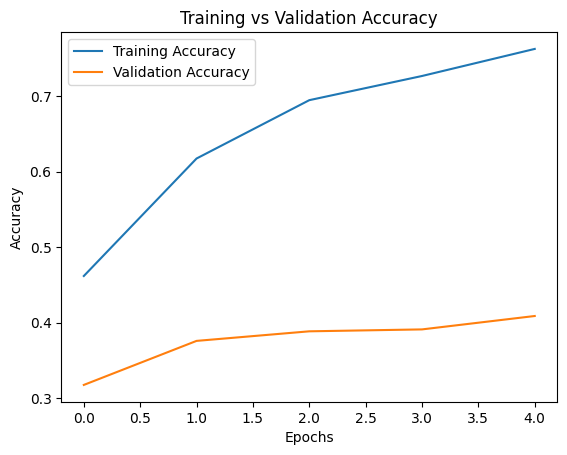

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Graph

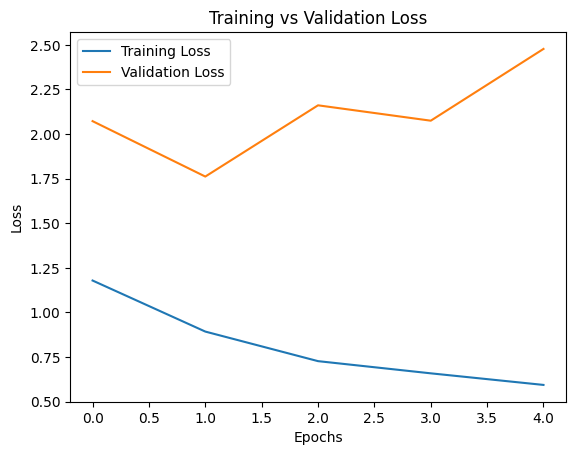

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model

In [16]:
score = model.evaluate(test)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.4219 - loss: 2.3799
Test Loss: 2.4769256114959717
Test Accuracy: 0.408629447221756


#  Predict Output for a New Image

In [19]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(15).jpg', target_size=(128, 128))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

result = model.predict(img)
print(result)

class_names = list(train.class_indices.keys())
predicted_class = class_names[np.argmax(result)]
print("Predicted Tumor Type:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.00749887 0.0029741  0.0259789  0.9635482 ]]
Predicted Tumor Type: pituitary_tumor


In [20]:
model.save("brain_tumor_classification_model.h5")

# VGG16

## What is VGG16?
VGG16 is a Convolutional Neural Network (CNN) model developed by the Visual Geometry Group (VGG) at the University of Oxford. The "16" in VGG16 stands for 16 weight layers (13 convolutional layers + 3 fully connected layers).

It became famous for its simplicity and effectiveness, especially during the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2014, where it performed remarkably well.

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Load VGG16 as Feature Extractor

In [22]:
vgg = VGG16(
    weights='imagenet',      # Load pre-trained weights
    include_top=False,       # Exclude default fully connected layers
    input_shape=(224, 224, 3) # Input image size required by VGG16
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Freeze VGG16 Layers (so they're not re-trained)

In [24]:
for layer in vgg.layers:
    layer.trainable = False

## Build the model

In [25]:
x = vgg.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## compile the model

In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Update Data Generator Target Size to 224×224

In [27]:
train = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## Train the model

In [28]:
history = model.fit(
    train,
    validation_data=test,
    epochs=5
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 965s 11s/step - accuracy: 0.4634 - loss: 1.2573 - val_accuracy: 0.4746 - val_loss: 1.4550
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 979s 11s/step - accuracy: 0.7134 - loss: 0.7094 - val_accuracy: 0.5635 - val_loss: 1.3992
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 964s 11s/step - accuracy: 0.7640 - loss: 0.5934 - val_accuracy: 0.5761 - val_loss: 1.3885
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 981s 11s/step - accuracy: 0.8030 - loss: 0.5084 - val_accuracy: 0.6421 - val_loss: 1.2986
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 963s 11s/step - accuracy: 0.8150 - loss: 0.4726 - val_accuracy: 0.6396 - val_loss: 1.3469


## Evaluate the model

In [29]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 113s 9s/step - accuracy: 0.6584 - loss: 1.2567
Test Loss: 1.3469481468200684
Test Accuracy: 0.6395938992500305


## Generate Predictions

In [30]:
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)  # predicted class labels
y_true = test.classes                        # actual class labels
class_labels = list(test.class_indices.keys())  # ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step


## Prediction using new image

In [32]:
img = image.load_img('/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(15).jpg', target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

result = model.predict(img)
print(result)

class_names = list(train.class_indices.keys())
predicted_class = class_names[np.argmax(result)]
print("Predicted Tumor Type:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
[[2.3728340e-04 1.6367082e-03 1.9934156e-03 9.9613261e-01]]
Predicted Tumor Type: pituitary_tumor


In [33]:
model.save("brain_tumor_classification_model.h5")

# Conclusion
- In this brain tumor classification project, explored both a custom Convolutional Neural Network (CNN) and a transfer learning approach using the pre-trained VGG16 model on MRI images. The CNN model allowed us to design and understand the architecture from the ground up, while VGG16 leveraged deep feature representations learned from large-scale datasets to boost performance. Both models were trained using data augmentation and image preprocessing techniques to improve generalization and reduce overfitting. My experiment demonstrated that while the custom CNN performed well, the VGG16-based model achieved higher accuracy and robustness, showcasing the power of transfer learning in medical imaging tasks. With further enhancements and real-world data, such models have the potential to assist radiologists in the early and accurate diagnosis of brain tumors